In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import torch
from druxai.models.NN_minimal import Interaction_Model
from druxai.utils.data import DrugResponseDataset
from druxai.utils.dataframe_utils import split_data_by_cell_line_ids, standardize_molecular_data_inplace
from torch.utils.data import DataLoader
import pandas as pd
from scipy.stats import spearmanr
from druxai.utils.plotting import plot_ordered_r_scores

In [36]:
# Checkpoint path
# Always safe specific config with a run! Important especially if seed is changed because then we have other splits!

ckpt_path = "/Users/niklaskiermeyer/Desktop/Codespace/DruxAI/results/training/ckpt.pt"

checkpoint = torch.load(ckpt_path)
cfg = checkpoint["config"]

In [168]:
# Load data
data = DrugResponseDataset(cfg["DATA_PATH"])
train_id, val_id, test_id = split_data_by_cell_line_ids(data.targets, seed=cfg["SEED"])
standardize_molecular_data_inplace(data, train_id, val_id, test_id)

val_loader = DataLoader(
    data,
    sampler=val_id,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=6,
    persistent_workers=True
)

train_loader = DataLoader(
    data,
    sampler=train_id,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=6,
    persistent_workers=True
)

INFO     Loaded targets with shape: (556840, 8)                                                                    
INFO     Loaded molecular data with shape: (1479, 19193)                                                           


In [38]:
model = Interaction_Model(data)

model.load_state_dict(checkpoint["model"])
model.to("mps")
# Setup optimizers

predictions = []
targets = []
cell_lines = []
drugs = []
keys = []
with torch.no_grad():
    model.eval()
    for X, y, idx in val_loader:
        drug, molecular, outcome = (
            X["drug_encoding"].to("mps"),
            X["gene_expression"].to("mps"),
            y.to("mps")
        )

        # Assuming model.predict returns the predicted values
        prediction = model.forward(drug, molecular).reshape(-1).tolist()
        predictions.append(prediction)

        targets.append(y.reshape(-1).tolist())

        # Fetch cell line and drug from data.targets DataFrame
        cell_line = data.targets.iloc[idx]["cell_line"].to_list()
        compound = data.targets.iloc[idx]["DRUG"].to_list()

        cell_lines.append(cell_line)
        drugs.append(compound)
        keys.append([id.item() for id in idx])

In [39]:
data_dict = {
    "ID": keys,
    "Prediction": predictions,
    "Target": targets,
    "Cell_Line": cell_lines,
    "Drug": drugs
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(data_dict).apply(pd.Series.explode)

print(f"Overall R-Score: {spearmanr(results_df['Prediction'], results_df['Target'])[0]} \n")
print(results_df.head())

Overall R-Score: 0.15904451281920454 

     ID Prediction    Target   Cell_Line         Drug
0   218   0.083632  0.438643  ACH-000007   CYTARABINE
0   616   0.059449   0.36191  ACH-000007   EPINASTINE
0  1042  -0.740707 -0.883103  ACH-000007  FLOXURIDINE
0  1499  -0.255171 -0.430022  ACH-000007   VALRUBICIN
0  1940   0.037451  0.340511  ACH-000007    ADAPALENE


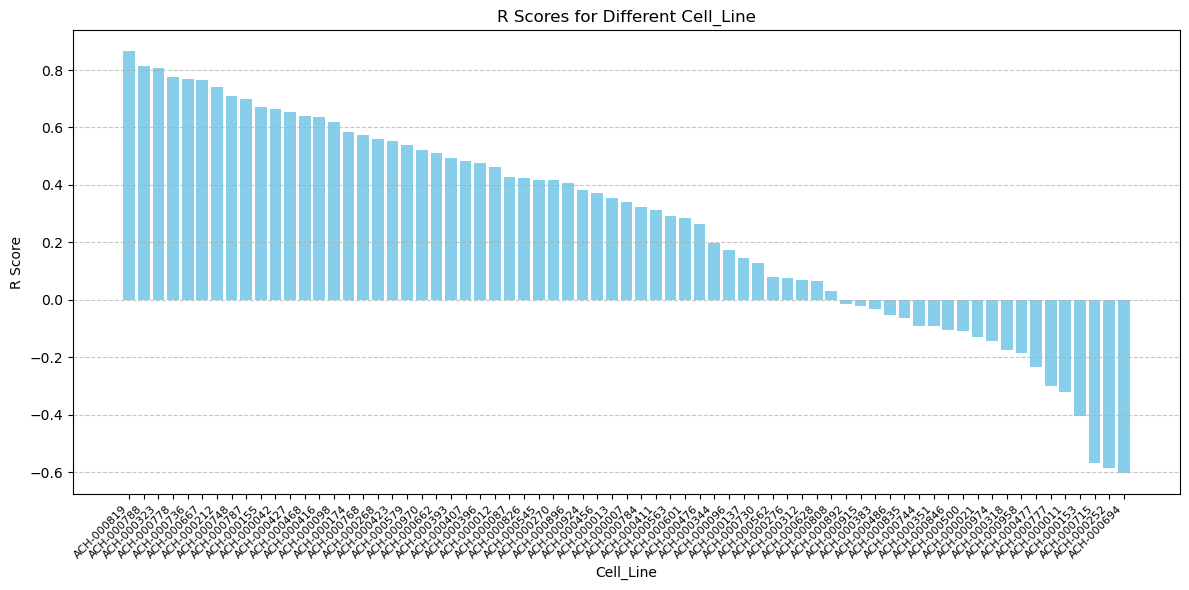

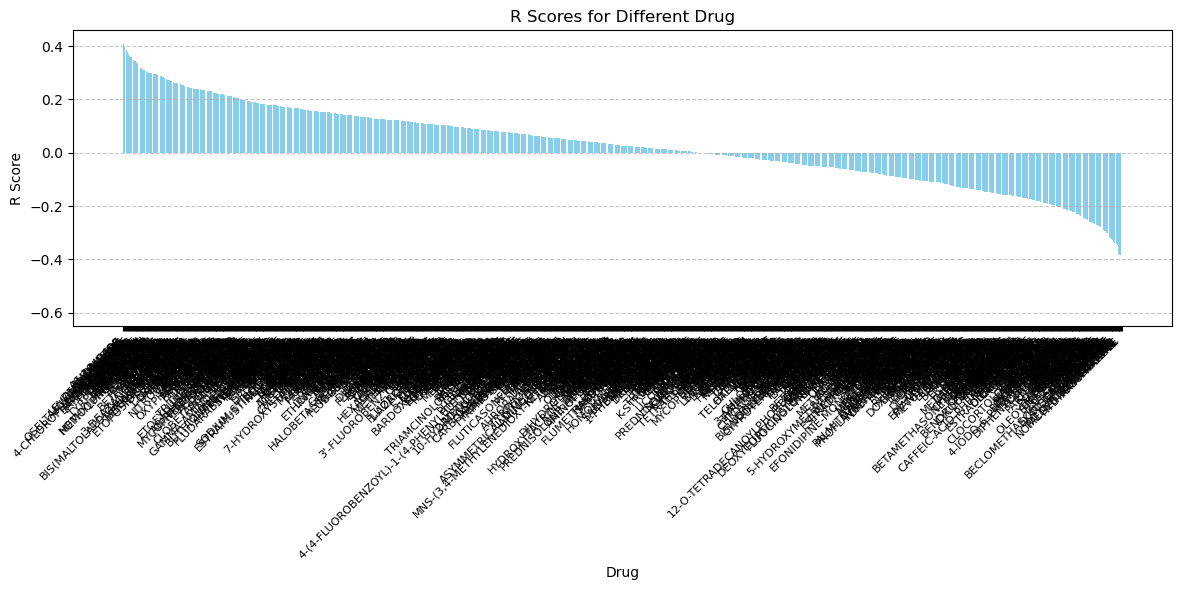

In [40]:
# Calculate R score for each cell line
group_by_features = ["Cell_Line", "Drug"]
grouped_dfs = {}
for group_by_feature in group_by_features:
    grouped_dfs[group_by_feature] = plot_ordered_r_scores(results_df, group_by_feature)

In [41]:
grouped_dfs

{'Cell_Line':          Group   R Score
 58  ACH-000819  0.864904
 56  ACH-000788  0.813731
 20  ACH-000323  0.807797
 53  ACH-000778  0.774158
 48  ACH-000736  0.769128
 ..         ...       ...
 1   ACH-000011 -0.322227
 10  ACH-000153 -0.405496
 46  ACH-000715 -0.567322
 14  ACH-000252 -0.587128
 45  ACH-000694 -0.602659
 
 [69 rows x 2 columns],
 'Drug':                     Group   R Score
 6                2,3-DCPE  0.408837
 85             AS-1949490  0.396721
 69              AMONAFIDE  0.391452
 953              SGI-1776  0.389842
 319           DEXRAZOXANE  0.386324
 ...                   ...       ...
 710   NOMEGESTROL-ACETATE -0.378238
 1007                  TC1 -0.384540
 496        HYDROCORTISONE -0.384615
 1074            TYLOXAPOL -0.402787
 82           ARIPIPRAZOLE -0.600000
 
 [1149 rows x 2 columns]}